# Multicriteria Spatial Analysis: Ideal areas for living in Cundinamarca   
# Part I

Geoprocesamiento 2025-1S  
Universidad Nacional de Colombia  
Authors: Alicia Arévalo Robinson and Ricardo Andrés Martinez Soto  
Link to repository: https://github.com/aliciaarevalor/multicriteria-analysis

## Objective
To identify the most suitable areas for living in Cundinamarca department using a multicriteria spatial analysis.  

## Import modules

In [28]:
import geopandas as gpd      
import numpy as np
import rasterio
import rasterio.plot
from rasterio.mask import mask
from rasterio.features import rasterize
import matplotlib.pyplot as plt  
import scipy.ndimage
import scipy.stats
import rasterio.merge
import rasterio.features
import matplotlib.pyplot as plt
from osgeo import gdal

## Input Data

Define the file paths for all spatial datasets used in the multicriteria analysis.


In [2]:
# Mean temperature
temp_path="./data/temperatura/SHP/ACC2014_TmMd_AA_1981_2010.shp"
# DEM Colombia
dem_col_path="./data/dem_colombia/SRTM30/SRTM_30_Col1.tif"
# Protected areas
runap_path="./data/areas_protegidas/runap.shp"
# Mining Titles
mining_path="./data/mineria_hidrocarburos/AreasMineriaeHidrocarburos.gpkg"
# Indigenous reserves
indigenous_path="./data/Resguardo_Indigena_Formalizado/Resguardo_Indigena_Formalizado.shp"
# Public services coverage
services_path="./data/acueducto/CoberturaServiciosPublicos.gpkg"
# Roads
road_path="./data/VIAS/VIAS.shp"
# Land cover
cover_path="./data/cover/cobertura_tierra_clc_2018.shp"
# Municipalities of Colombia
muni_path="./data/muni_category/municipios.shp"
# Populated Center
popcenter_path="./data/MGN2024_URB_ZONA_URBANA/MGN_URB_ZONA_URBANA.shp"
# Cundinamarca boundary
cundi_path="./data/cundinamarca.shp"

## Read and reproject vector data

Read all vector datasets using `geopandas` and reproject them to the EPSG:9377 coordinate reference system.  

This step ensures that all layers are aligned and compatible for further geoprocessing.


In [3]:
# Read and project to EPSG:9377
temp= gpd.read_file(temp_path).to_crs(epsg=9377)
runap = gpd.read_file(runap_path).to_crs(epsg=9377)
mining = gpd.read_file(mining_path).to_crs(epsg=9377)
indigenous = gpd.read_file(indigenous_path).to_crs(epsg=9377)
services = gpd.read_file(services_path).to_crs(epsg=9377)
cover = gpd.read_file(cover_path).to_crs(epsg=9377)
muni = gpd.read_file(muni_path).to_crs(epsg=9377)
road = gpd.read_file(road_path).to_crs(epsg=9377)
popcenter= gpd.read_file(popcenter_path).to_crs(epsg=9377)
cundi= gpd.read_file(cundi_path).to_crs(epsg=9377)

c:\Users\VICTUS\anaconda3\Lib\site-packages\pyogrio\geopandas.py:265: UserWarning: More than one layer found in 'AreasMineriaeHidrocarburos.gpkg': 'Títulos_mineros' (default), 'Bloques_de_exploración_petrolera'. Specify layer parameter to avoid this warning.
  result = read_func(
c:\Users\VICTUS\anaconda3\Lib\site-packages\pyogrio\raw.py:198: RuntimeWarning: Non-conformant content for record 1 in column FECHA_DE_E, 2015-03-05T00:00:00.0Z, successfully parsed
  return ogr_read(


## Filter relevant features from vector layers

To refine the analysis, filter each dataset to include only the most relevant features:

- **Roads**: select roads categorized as primary, secondary, tertiary, residential, and their respective connectors. These are assumed to be the most influential for accessibility.
- **Municipalities**: select only first, second, and third category municipalities (`Ley6172000`), which typically offer better infrastructure and services.
- **Populated Centers**: include only those classified as category 1 (`clas_ccdgo`), representing consolidated urban areas.


In [4]:
# Filter road network to include only relevant types for accessibility analysis
road = road[road["type"].isin([
    "primary", 
    "primary link", 
    "secondary", 
    "secondary link", 
    "tertiary", 
    "tertiary link", 
    "residential"
])]

# Filter municipalities to include only categories 1, 2, and 3 (according to Ley 617 de 2000)
muni = muni[muni["Ley6172000"].isin(["1", "2", "3"])]

# Filter populated centers to include only category 1
popcenter = popcenter[popcenter["clas_ccdgo"].isin(["1"])]

# Filter public service coverage to include only municipalities from Cundinamarca (codes starting with '25')
services = services[services['COD_MPIO'].astype(str).str.startswith('25')]


## Clip layers to Cundinamarca

To focus the analysis on the department of **Cundinamarca**, we perform a spatial intersection (`overlay`) between each vector layer and the department boundary.

This ensures that only the portions of the datasets within Cundinamarca are retained, reducing computational load and aligning the study area with the project's geographic scope.

In [5]:
temp = gpd.overlay(temp, cundi, how='intersection')
runap = gpd.overlay(runap, cundi, how='intersection')
mining = gpd.overlay(mining, cundi, how='intersection')
indigenous = gpd.overlay(indigenous, cundi, how='intersection')
services = gpd.overlay(services, cundi, how='intersection')
cover = gpd.overlay(cover, cundi, how='intersection')
muni = gpd.overlay(muni, cundi, how='intersection')
popcenter = gpd.overlay(popcenter, cundi, how='intersection')
road = gpd.overlay(road, cundi, how='intersection')

C:\Users\VICTUS\AppData\Local\Temp\ipykernel_30632\1283390453.py:2: UserWarning: `keep_geom_type=True` in overlay resulted in 24 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  runap = gpd.overlay(runap, cundi, how='intersection')


In [7]:
# Remove duplicate columns before saving each layer
if 'SHAPE_Leng' in muni.columns and 'Shape_Leng' in muni.columns:
    muni = muni.drop(columns=['Shape_Leng'])
if 'SHAPE_Area' in muni.columns and 'Shape_Area' in muni.columns:
    muni = muni.drop(columns=['Shape_Area'])

if 'SHAPE_Leng' in road.columns and 'Shape_Leng' in road.columns:
    road = road.drop(columns=['Shape_Leng'])
if 'SHAPE_Area' in road.columns and 'Shape_Area' in road.columns:
    road = road.drop(columns=['Shape_Area'])

### Export clipped layers to GeoPackage

In [8]:
# Define output GeoPackage path
output_gpkg = "./data/clip/clipped_layers.gpkg"

# Save each GeoDataFrame as a separate layer in the GeoPackage
temp.to_file(output_gpkg, layer='temp', driver="GPKG")
runap.to_file(output_gpkg, layer='runap', driver="GPKG")
mining.to_file(output_gpkg, layer='mining', driver="GPKG")
indigenous.to_file(output_gpkg, layer='indigenous', driver="GPKG")
services.to_file(output_gpkg, layer='services', driver="GPKG")
cover.to_file(output_gpkg, layer='cover', driver="GPKG")
muni.to_file(output_gpkg, layer='muni', driver="GPKG")
road.to_file(output_gpkg, layer='road', driver="GPKG")

## Visualization of vector layers

To verify the integrity and spatial distribution of the processed input data, we visualize the layers used in the multicriteria analysis.  

These visualizations ensure that the spatial datasets are correctly clipped, projected, and categorized before moving into further analysis stages.


C:\Users\VICTUS\AppData\Local\Temp\ipykernel_30632\1267990713.py:41: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  cover.plot(column="leyenda", ax=axs[1, 1], legend=False, color=cover["leyenda"].map(random_colors_cover))


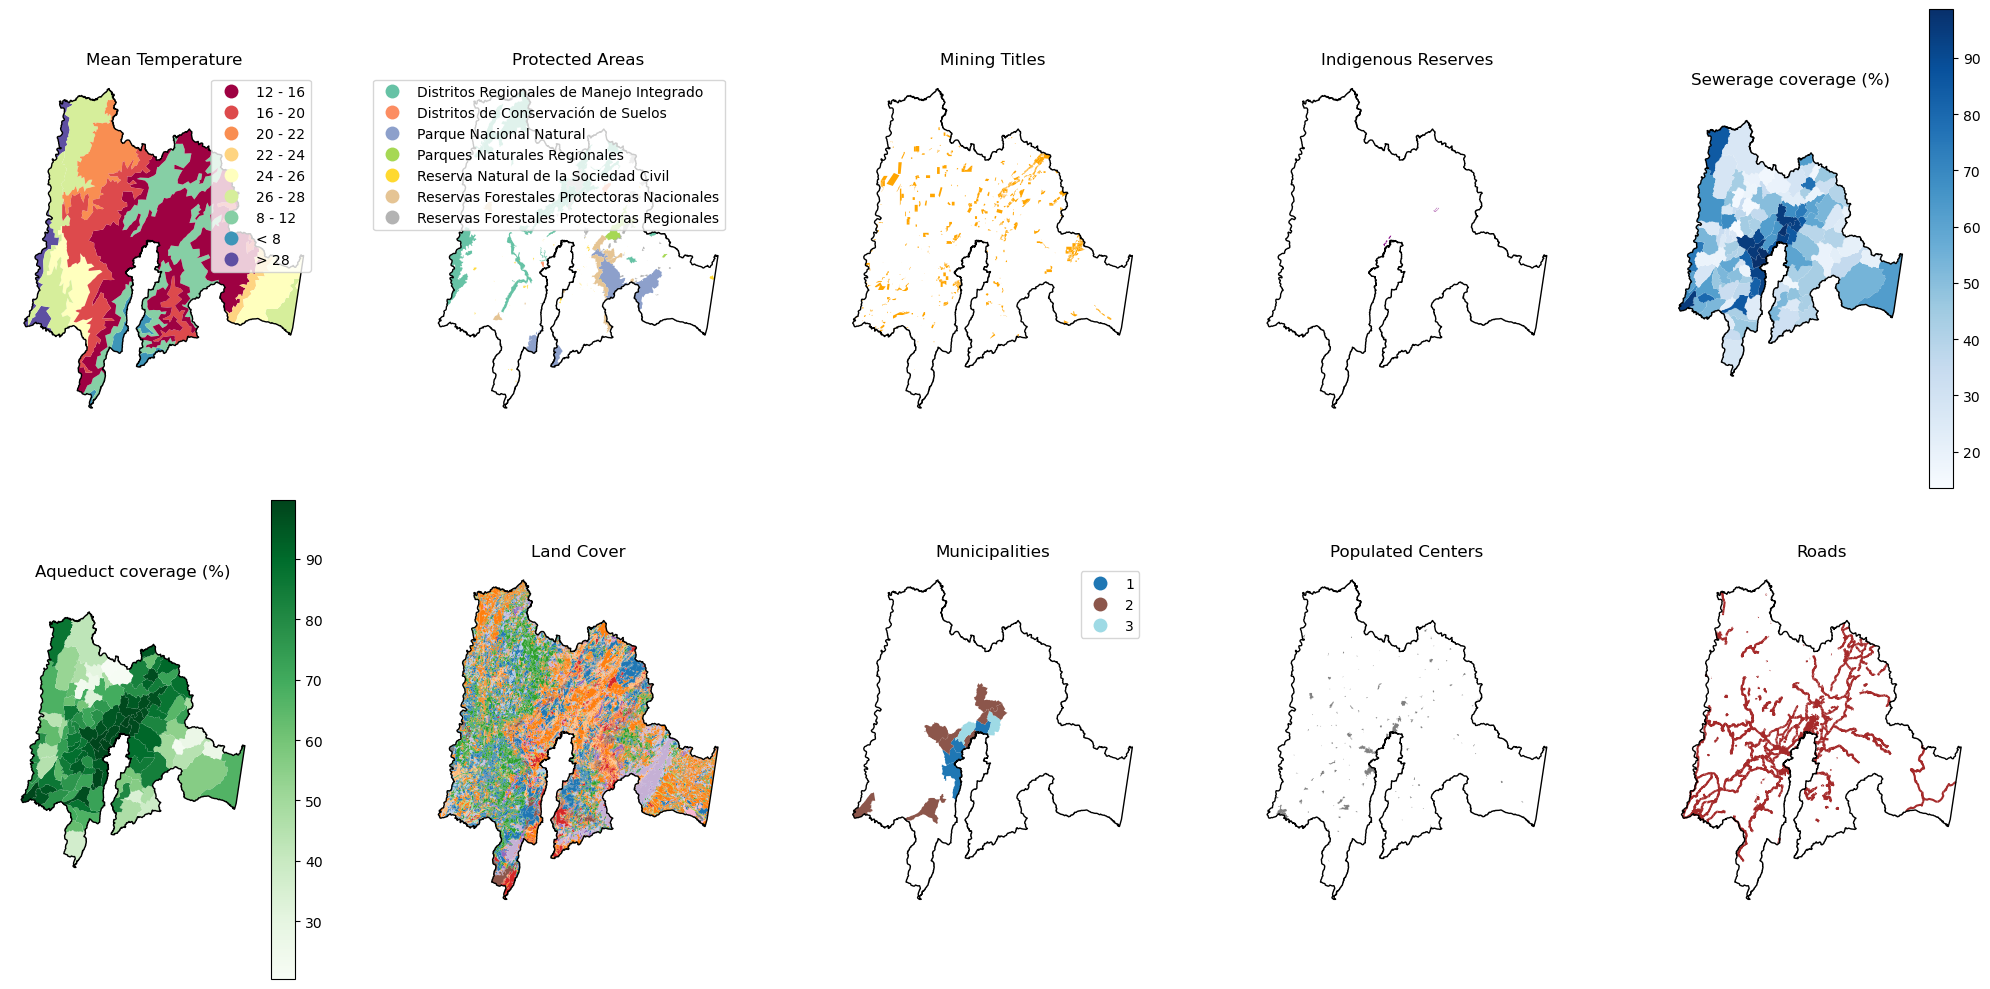

In [9]:

fig, axs = plt.subplots(2, 5, figsize=(20, 10))
# 1. Temperature
temp.plot(column="RANGO", ax=axs[0, 0], legend=True, cmap="Spectral")
cundi.boundary.plot(ax=axs[0, 0], color="black", linewidth=1)
axs[0, 0].set_title("Mean Temperature")
axs[0, 0].set_axis_off()

# 2. Runap
runap.plot(column="ap_categor", ax=axs[0, 1], legend=True, cmap="Set2")
cundi.boundary.plot(ax=axs[0, 1], color="black", linewidth=1)
axs[0, 1].set_title("Protected Areas")
axs[0, 1].set_axis_off()

# 3. Mining 
mining.plot(ax=axs[0, 2], color="orange")
cundi.boundary.plot(ax=axs[0, 2], color="black", linewidth=1)
axs[0, 2].set_title("Mining Titles")
axs[0, 2].set_axis_off()

# 4. Indigenous: single color (e.g., purple)
indigenous.plot(ax=axs[0, 3], color="purple")
cundi.boundary.plot(ax=axs[0, 3], color="black", linewidth=1)
axs[0, 3].set_title("Indigenous Reserves")
axs[0, 3].set_axis_off()

# 5. Services
# Sewerage coverage
services.plot(column="Cob__Alcan", ax=axs[0, 4], legend=True, cmap="Blues")
cundi.boundary.plot(ax=axs[0, 4], color="black", linewidth=1)
axs[0, 4].set_title("Sewerage coverage (%)")
axs[0, 4].set_axis_off()
# Aqueduct coverage
services.plot(column="Cob__Acued", ax=axs[1, 0], legend=True, cmap="Greens")
cundi.boundary.plot(ax=axs[1, 0], color="black", linewidth=1)
axs[1, 0].set_title("Aqueduct coverage (%)")
axs[1, 0].set_axis_off()

# 6. Land Cover
unique_leyenda = cover["leyenda"].unique()
random_colors_cover = dict(zip(unique_leyenda, plt.cm.tab20(np.linspace(0, 1, len(unique_leyenda)))))
cover.plot(column="leyenda", ax=axs[1, 1], legend=False, color=cover["leyenda"].map(random_colors_cover))
cundi.boundary.plot(ax=axs[1, 1], color="black", linewidth=1)
axs[1, 1].set_title("Land Cover")
axs[1, 1].set_axis_off()

# 7. Municipalities of Cundinamarca
muni.plot(column="Ley6172000", ax=axs[1, 2], legend=True, cmap="tab20")
cundi.boundary.plot(ax=axs[1, 2], color="black", linewidth=1)
axs[1, 2].set_title("Municipalities")
axs[1, 2].set_axis_off()

# 8. Populated Center
popcenter.plot(ax=axs[1, 3], color="grey")
cundi.boundary.plot(ax=axs[1, 3], color="black", linewidth=1)
axs[1, 3].set_title("Populated Centers")
axs[1, 3].set_axis_off() 

# 9. Roads
road.plot(ax=axs[1, 4], color="brown")
cundi.boundary.plot(ax=axs[1, 4], color="black", linewidth=1)
axs[1, 4].set_title("Roads")
axs[1, 4].set_axis_off()

plt.tight_layout()
plt.show()

## Read raster data

### Load Digital Elevation Model (DEM)

Read the Digital Elevation Model (DEM) for Colombia using `rasterio`. This raster dataset provides elevation values used to derive the slope, which is one of the criteria in the suitability analysis.  


In [10]:
with rasterio.open(dem_col_path) as src:
    dem_col = src.read(1)  # Read the first raster band (elevation values)
    dem_col_meta = src.meta # Read metadata such as dimensions, CRS, data type, and affine transform

dem_col_meta

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': -3.4028230607370965e+38,
 'width': 38951,
 'height': 51271,
 'count': 1,
 'crs': CRS.from_wkt('PROJCS["MAGNA_CTM12",GEOGCS["MAGNA-SIRGAS",DATUM["Marco_Geocentrico_Nacional_de_Referencia",SPHEROID["GRS 1980",6378137,298.257222101004,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6686"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4686"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",4],PARAMETER["central_meridian",-73],PARAMETER["scale_factor",0.9992],PARAMETER["false_easting",5000000],PARAMETER["false_northing",2000000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'),
 'transform': Affine(38.21851414258779, 0.0, 4280523.4007429285,
        0.0, -38.2185141425878, 2996969.6092570713)}

### Clip DEM

To extract only the relevant elevation data for our study area, we clip the national-scale DEM to the **Cundinamarca** boundary using `rasterio.mask`.

### Steps performed:
- Ensure the vector geometry (Cundinamarca boundary) is in the same CRS as the DEM raster.
- Convert the geometry to GeoJSON-like format required for masking.
- Clip the DEM using the geometry and update the raster metadata (dimensions, transform, etc.).
- Save the resulting clipped raster (`dem_cundi.tif`) for further analysis, such as slope calculation.

This ensures our terrain-based analysis is restricted to the department of interest.


In [11]:
# Ensure geometry is in the same CRS as the raster
with rasterio.open(dem_col_path) as src:
    if cundi.crs != src.crs:
        cundi = cundi.to_crs(src.crs)

    # Get geometry as GeoJSON-like mapping
    geoms = cundi.geometry.values
    geoms = [geom.__geo_interface__ for geom in geoms]

    # Clip the raster
    dem_cundi, out_transform = mask(src, geoms, crop=True)
    out_meta = src.meta.copy()
    out_meta.update({
        "driver": "GTiff",
        "height": dem_cundi.shape[1],
        "width": dem_cundi.shape[2],
        "transform": out_transform
    })

# Save the clipped raster
with rasterio.open("./data/raster/dem_cundi.tif", "w", **out_meta) as dest:
    dest.write(dem_cundi)

dem_cundi_path= "./data/raster/dem_cundi.tif"

### Load clipped DEM

In [12]:
with rasterio.open(dem_cundi_path) as src:
    dem_cundi = src.read(1)
    dem_cundi_meta = src.meta 

dem_cundi_meta

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': -3.4028230607370965e+38,
 'width': 5336,
 'height': 6094,
 'count': 1,
 'crs': CRS.from_wkt('PROJCS["MAGNA_CTM12",GEOGCS["MAGNA-SIRGAS",DATUM["Marco_Geocentrico_Nacional_de_Referencia",SPHEROID["GRS 1980",6378137,298.257222101004,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6686"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4686"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",4],PARAMETER["central_meridian",-73],PARAMETER["scale_factor",0.9992],PARAMETER["false_easting",5000000],PARAMETER["false_northing",2000000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'),
 'transform': Affine(38.21851414258779, 0.0, 4790243.723862622,
        0.0, -38.2185141425878, 2203209.2890296653)}

## Calculate slope from DEM

We use the `gdaldem` command-line utility to compute the **slope** (in degrees) from the clipped DEM of Cundinamarca.

The slope raster helps identify **flat or gently sloping areas**. The resulting file (`*_slope.tif`) is saved in the same directory as the DEM.

In [13]:
# Import the os module to interact with the operating system
import os

# Define the output file path for the slope raster
# It takes the original DEM path and appends '_slope.tif' to the filename
cundi_slope  = os.path.splitext(dem_cundi_path)[0] + '_slope.tif'

# Use GDAL's command-line tool 'gdaldem' to compute the slope from the DEM
# The output is saved as a GeoTIFF file
os.system(f'gdaldem slope "{dem_cundi_path}" "{cundi_slope}" -of GTiff')

0

### Load slope raster

In [14]:
# Define the file path to the slope raster derived from the DEM
cundi_slope_path = "./data/raster/dem_cundi_slope.tif"


with rasterio.open(cundi_slope_path) as src:
    cundi_slope = src.read(1)
    cundi_slope_meta = src.meta # Read metadata such as dimensions, CRS, data type, and affine transform
    slope_bounds = src.bounds   # Get the spatial extent (bounding box) of the raster


In [15]:
print("Maximum slope (degrees):", np.nanmax(cundi_slope))

Maximum slope (degrees): 87.59907


### Visualize slope raster

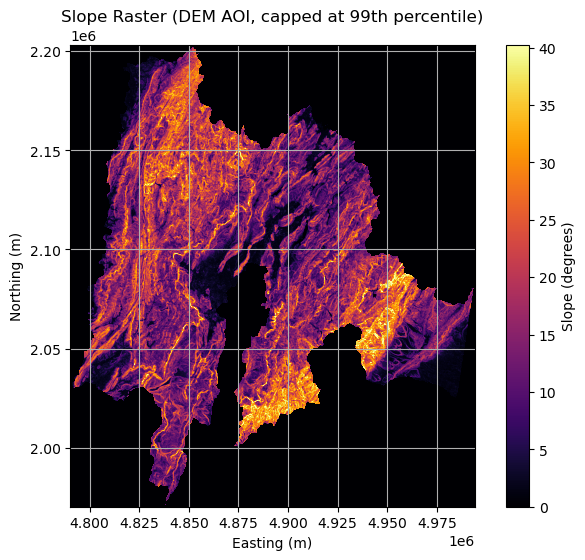

In [16]:
# Calculate extent for real-world coordinates
extent = [slope_bounds.left, slope_bounds.right, slope_bounds.bottom, slope_bounds.top]

# Cap color scale at 99th percentile for better visualization
vmax = np.percentile(cundi_slope, 99)

plt.figure(figsize=(8, 6))
plt.imshow(cundi_slope, cmap="inferno", extent=extent, origin='upper', vmin=0, vmax=vmax)
plt.colorbar(label="Slope (degrees)")
plt.title("Slope Raster (DEM AOI, capped at 99th percentile)")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.grid(True)
plt.show()

## Rasterization of vector layers

In this step, we convert selected vector layers into raster format to align them with the reference DEM grid.

#### Procedure:
- The **transform**, **shape**, and **CRS** are loaded from the clipped DEM (`dem_cundi_path`) to serve as the spatial reference.
- A general-purpose function `rasterise_layer()` is defined to:
  - Rasterize non-empty `GeoDataFrame`s.
  - Burn values of `1` into the raster where geometries are present.
  - Return an all-zero raster if the input layer is empty.

#### Rasterized layers:
- `runap` (Protected areas)
- `mining` (Mining titles)
- `indigenous` (Indigenous reserves)
- `road` (Roads)
- `popcenter` (Population centers)


In [ ]:
# Load reference parameters from the reprojected DEM 
with rasterio.open(dem_cundi_path) as src:
    dem_meta = src.meta
    transform = src.transform
    out_shape = (src.height, src.width)
    crs = src.crs

print("Reference transform and shape loaded from DEM")

#  Rasterise function 
def rasterise_layer(gdf, transform, out_shape, burn_value=1, layer_name="Layer"):
    """
    Rasterise a GeoDataFrame to match the reference raster grid.
    """
    if gdf.empty:
        print(f" {layer_name} is empty. Returning empty raster.")
        return np.zeros(out_shape, dtype="uint8")

    geometries = [(geom, burn_value) for geom in gdf.geometry if geom is not None]

    raster = rasterize(
        geometries,
        out_shape=out_shape,
        transform=transform,
        fill=0,
        dtype="uint8"
    )

    print(f" Rasterised: {layer_name}")
    return raster

#  Rasterise each vector layer 
runap_raster = rasterise_layer(runap, transform, out_shape, layer_name="runap")
mining_raster = rasterise_layer(mining, transform, out_shape, layer_name="mining")
indigenous_raster = rasterise_layer(indigenous, transform, out_shape, layer_name="indigenous")
road_raster = rasterise_layer(road, transform, out_shape, layer_name="road")
popcenter_raster = rasterise_layer(popcenter, transform, out_shape, layer_name="popcenter")


Reference transform and shape loaded from DEM
 Rasterised: runap
 Rasterised: mining
 Rasterised: indigenous
 Rasterised: road
 Rasterised: popcenter


#### Export rasterized layers

Each rasterized vector layer is saved as a GeoTIFF file using metadata from the reference DEM.

In [19]:
# Use the DEM metadata as a template, but update count and dtype
meta = dem_meta.copy()
meta.update({
    "count": 1,
    "dtype": "uint8",
    "nodata": 255  # Use 255 as nodata for uint8
})

with rasterio.open("./data/raster/runap_raster.tif", "w", **meta) as dst:
    dst.write(runap_raster, 1)

with rasterio.open("./data/raster/mining_raster.tif", "w", **meta) as dst:
    dst.write(mining_raster, 1)

with rasterio.open("./data/raster/indigenous_raster.tif", "w", **meta) as dst:
    dst.write(indigenous_raster, 1)

with rasterio.open("./data/raster/road_raster.tif", "w", **meta) as dst:
    dst.write(road_raster, 1)

with rasterio.open("./data/raster/popcenter_raster.tif", "w", **meta) as dst:
    dst.write(popcenter_raster, 1)

## Rasterize temperature

This section converts temperature range polygons into a categorical raster format. It follows this steps:

1. A custom order is defined to assign consistent values across the temperature ranges:

```python
custom_order = ["< 8", "8 - 12", "12 - 16", "16 - 20", "20 - 22",
    "22 - 24", "24 - 26", "26 - 28", "> 28"]
```
2. Only categories present in the `temp["RANGO"]` column are used to create the raster  

3. Assign numeric values: a dictionary maps each temperature range to a unique integer value (starting from 1):

```python
rango_vals = {cat: i+1 for i, cat in enumerate(present_rangos)}
```

4. Prepare Geometry-Value Pairs
Each polygon in the GeoDataFrame is paired with its corresponding category value:


5. Rasterization

6. Output: the final raster assigns an integer to each pixel based on the RANGO category. A legend is printed for reference

In [20]:
# Rasterize the temperature layer using the "RANGO" column
# Assign a unique value to each RANGO category

# Create a dictionary of unique values for each RANGO, ordered by a custom list

# If your RANGO values are just "12 - 16", "16 - 20", etc., use:
custom_order = [
    "< 8",
    "8 - 12",
    "12 - 16",
    "16 - 20",
    "20 - 22",
    "22 - 24",
    "24 - 26",
    "26 - 28",
    "> 28"
]

# Filter only those present in your data
present_rangos = [r for r in custom_order if r in temp["RANGO"].unique()]

# Create dictionary with your custom order
rango_vals = {cat: i+1 for i, cat in enumerate(present_rangos)}

# Create geometries with the corresponding RANGO value
geometries = [
    (geom, rango_vals[rango])
    for geom, rango in zip(temp.geometry, temp["RANGO"])
    if geom is not None
]

# Rasterize
from rasterio.features import rasterize

temp_raster = rasterize(
    geometries,
    out_shape=out_shape,
    transform=transform,
    fill=0,
    dtype="uint8"
)

print("Temperature rasterization completed. Value legend:")
for k, v in rango_vals.items():
    print(f"{v}: {k}")

Temperature rasterization completed. Value legend:
1: < 8
2: 8 - 12
3: 12 - 16
4: 16 - 20
5: 20 - 22
6: 22 - 24
7: 24 - 26
8: 26 - 28
9: > 28


### Export temperature raster

In [21]:
temp_raster_path = "./data/raster/temp_raster.tif"

# Use the DEM metadata as a template, but update count and dtype
meta = dem_meta.copy()
meta.update({
    "count": 1,
    "dtype": "float32"
})

with rasterio.open(temp_raster_path, "w", **meta) as dst:
    dst.write(temp_raster, 1)


## Rasterize services

### Sewerage

Sewerage coverage data is organized by ascending values to prepare it for rasterization. Geometries with valid numeric coverage values are selected and paired for conversion. Using the spatial resolution and extent of a reference DEM, the sewerage data is rasterized to produce a continuous surface representing the distribution of coverage across the area of interest. This raster layer is then saved in GeoTIFF format, maintaining the spatial metadata of the DEM but with a floating-point data type to preserve value precision. The result is a georeferenced raster suitable for spatial analysis, visualization, or integration into multi-criteria evaluation frameworks.


In [22]:
# Order sewerage coverage in ascending order
services = services.sort_values(by="Cob__Alcan", ascending=True)

# Rasterize "Cob__Alcan" (Sewerage coverage)
geoms_alcan = [
    (geom, value) for geom, value in zip(services.geometry, services["Cob__Alcan"])
    if geom is not None and not np.isnan(value)
]
services_alcan_raster = rasterize(
    geoms_alcan,
    out_shape=out_shape,
    transform=transform,
    fill=0,
    dtype="float32"
)

# Save both rasters
with rasterio.open("./data/raster/sewerage_raster.tif", "w", **{**dem_meta, "count": 1, "dtype": "float32"}) as dst:
    dst.write(services_alcan_raster, 1)

### Aqueduct

Aqueduct coverage values are sorted in ascending order to standardize the input before rasterization. Valid geometries and their associated coverage values are extracted and transformed into a raster format that matches the spatial characteristics of a reference DEM. This process generates a continuous raster layer that spatially represents the level of aqueduct service coverage. The resulting raster is stored as a GeoTIFF file using 32-bit float precision, allowing for detailed representation and future spatial analyses.


In [23]:
# Order aqueduct coverage in ascending order
services = services.sort_values(by="Cob__Acued", ascending=True)

# Rasterize "Cob__Acued" (Aqueduct coverage)
geoms_acued = [
    (geom, value) for geom, value in zip(services.geometry, services["Cob__Acued"])
    if geom is not None and not np.isnan(value)
]
services_acued_raster = rasterize(
    geoms_acued,
    out_shape=out_shape,
    transform=transform,
    fill=0,
    dtype="float32"
)

# Save both rasters
with rasterio.open("./data/raster/aqueduct_raster.tif", "w", **{**dem_meta, "count": 1, "dtype": "float32"}) as dst:
    dst.write(services_acued_raster, 1)

## Rasterize land cover

Land cover data is rasterized based on categorical values in the "nivel_1" column. Each unique category is assigned a numeric code to facilitate raster representation. The corresponding geometries and codes are paired and converted into a raster format, preserving the spatial resolution and extent of a reference DEM. The resulting raster layer provides a spatially explicit view of land cover classes and is saved as a 32-bit float GeoTIFF for use in subsequent geospatial analyses.


In [29]:
# Rasterize the "cover" layer based on the column "nivel_|"

# Create a dictionary of unique values for each "nivel_|" category
nivel_vals = {cat: i+1 for i, cat in enumerate(sorted(cover["nivel_1"].unique()))}

# Create geometries with the corresponding "nivel_|" value
geometries = [
    (geom, nivel_vals[nivel])
    for geom, nivel in zip(cover.geometry, cover["nivel_1"])
    if geom is not None
]

from rasterio.features import rasterize

cover_raster = rasterize(
    geometries,
    out_shape=out_shape,
    transform=transform,
    fill=0,
    dtype="float32"
)

# Save the raster
cover_raster_path = "./data/raster/cover_raster.tif"
meta = dem_meta.copy()
meta.update({
    "count": 1,
    "dtype": "float32"
})

with rasterio.open(cover_raster_path, "w", **meta) as dst:
    dst.write(cover_raster, 1)

## Rasterization of Municipal Categories

A raster layer is generated to represent municipal categories defined in the "Ley6172000" column. Each unique category is mapped to a numeric code, which is then assigned to the corresponding geometry. The features are rasterized according to a reference spatial extent and resolution. The output raster encodes each category as an integer value. 


In [30]:
# Rasterize the temperature layer using the "RANGO" column
# Assign a unique value to each RANGO category

# Create a dictionary of unique values for each RANGO
rango_vals = {cat: i+1 for i, cat in enumerate(sorted(muni["Ley6172000"].unique()))}

# Create geometries with the corresponding RANGO value
geometries = [
    (geom, rango_vals[rango])
    for geom, rango in zip(muni.geometry, muni["Ley6172000"])
    if geom is not None
]

# Rasterize
from rasterio.features import rasterize

muni_raster = rasterize(
    geometries,
    out_shape=out_shape,
    transform=transform,
    fill=0,
    dtype="uint8"
)

print("Muni rasterization completed. Value legend:")
for k, v in rango_vals.items():
    print(f"{v}: {k}")

Muni rasterization completed. Value legend:
1: 1
2: 2
3: 3


### Export municipal raster

In [31]:
muni_raster_path = "./data/raster/muni_raster.tif"

# Use the DEM metadata as a template, but update count and dtype
meta = dem_meta.copy()
meta.update({
    "count": 1,
    "dtype": "float32"
})

with rasterio.open(muni_raster_path, "w", **meta) as dst:
    dst.write(muni_raster, 1)

## Visualization of rasters

The following figure displays the spatial distribution of the raster layers used in the analysis. These rasters represent a variety of environmental, infrastructural, and administrative features relevant to the study area:

- **Mean Temperature** (°C): Range data showing average temperature values.
- **Protected Areas**: Categorical data representing national natural parks and other conservation zones.
- **Mining Titles**: Categorical data indicating the presence of mining concessions.
- **Indigenous Reserves**: Categorical data highlighting territories of recognized indigenous communities.
- **Sewerage Coverage (%)**: Range data showing the percentage of sewerage coverage.
- **Aqueduct Coverage (%)**: Range data showing the percentage of aqueduct coverage.
- **Land Cover**: Categorical classification of surface cover types (e.g., vegetation, water, urban).
- **Municipalities (Law 617/2000)**: Categorical classification of municipalities based on Law 617/2000.
- **Road Network**: Binary raster showing road presence.
- **Populated Centers**: Binary raster representing location of urban settlements.


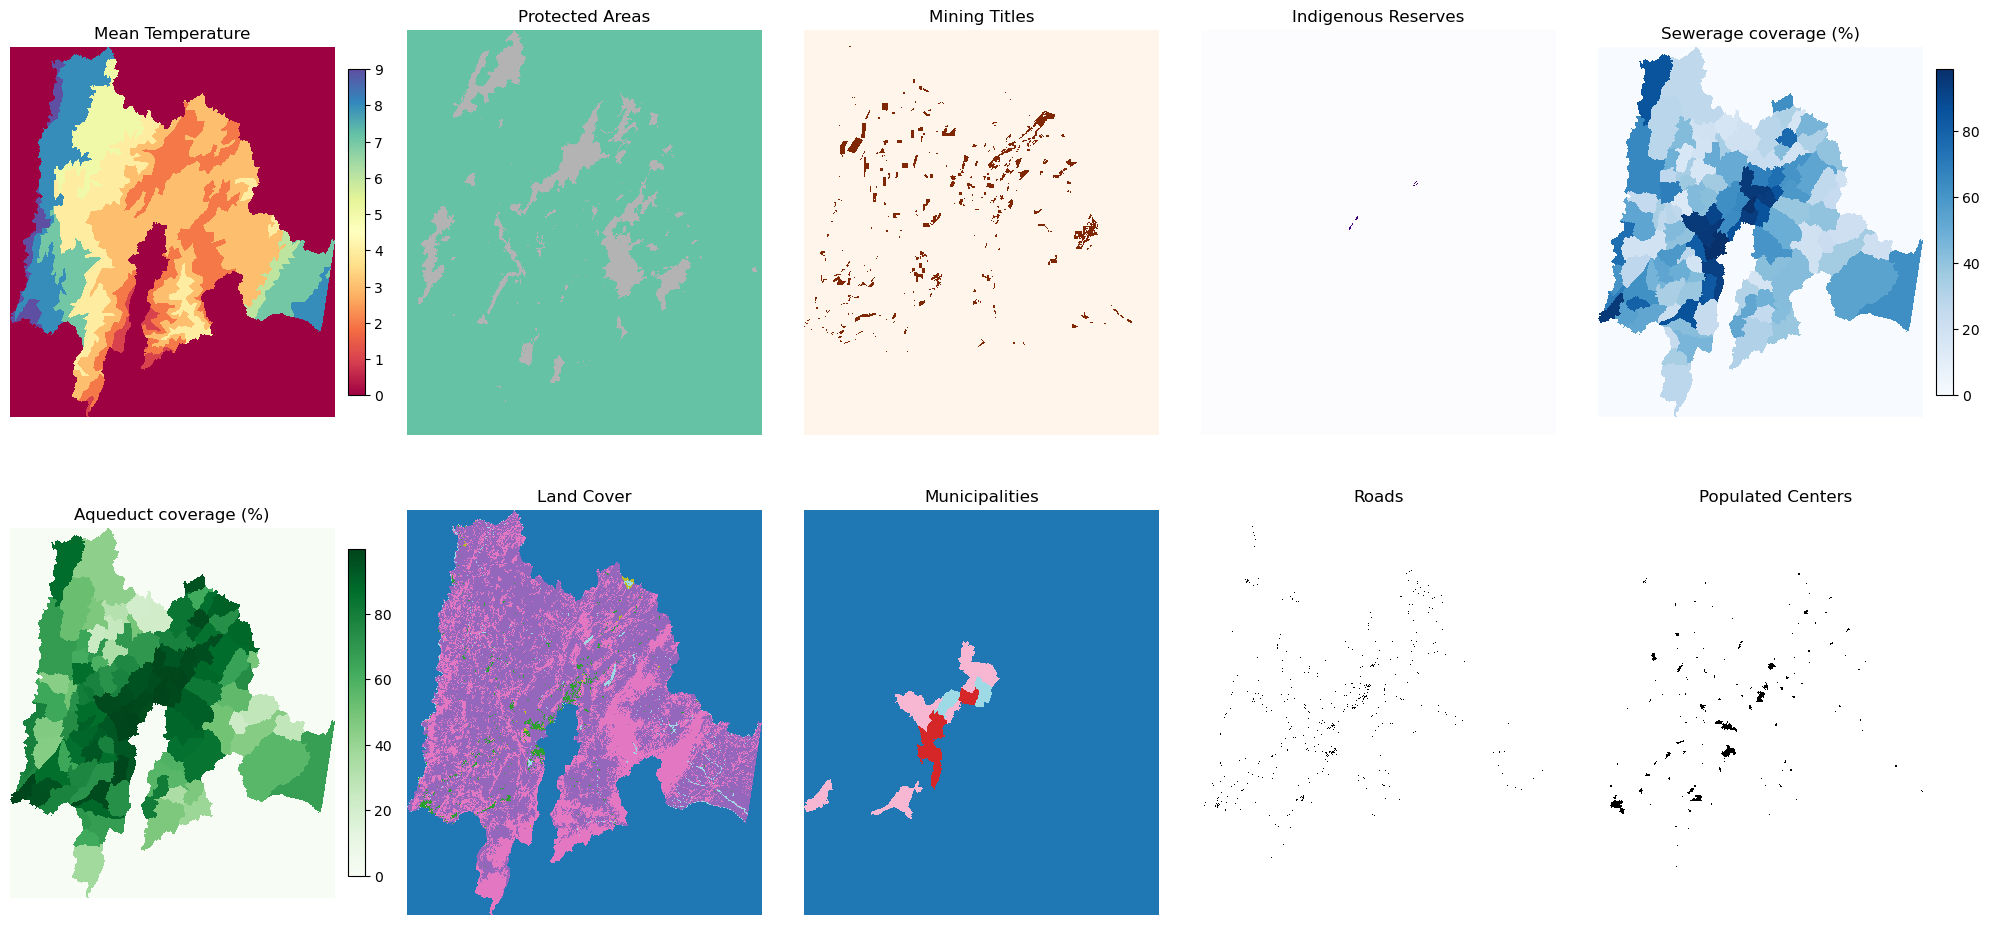

In [27]:


# Paths to your rasters
rasters = [
    ("./data/raster/temp_raster.tif", "Mean Temperature", "Spectral"),
    ("./data/raster/runap_raster.tif", "Protected Areas", "Set2"),
    ("./data/raster/mining_raster.tif", "Mining Titles", "Oranges"),
    ("./data/raster/indigenous_raster.tif", "Indigenous Reserves", "Purples"),
    ("./data/raster/sewerage_raster.tif", "Sewerage coverage (%)", "Blues"),
    ("./data/raster/aqueduct_raster.tif", "Aqueduct coverage (%)", "Greens"),
    ("./data/raster/cover_raster.tif", "Land Cover", "tab20"),
    ("./data/raster/muni_raster.tif", "Municipalities", "tab20"),
    ("./data/raster/road_raster.tif", "Roads", "Greys"),
    ("./data/raster/popcenter_raster.tif", "Populated Centers", "Greys")
]

fig, axs = plt.subplots(2, 5, figsize=(20, 10))

for i, (raster_path, title, cmap) in enumerate(rasters):
    row, col = divmod(i, 5)
    with rasterio.open(raster_path) as src:
        img = src.read(1)
        # Mask nodata for display
        if src.nodata is not None:
            img = np.ma.masked_equal(img, src.nodata)
        # For categorical rasters, use discrete colormap
        if cmap in ["tab20", "Set2", "Oranges", "Purples"]:
            im = axs[row, col].imshow(img, cmap=cmap, interpolation="none")
        else:
            im = axs[row, col].imshow(img, cmap=cmap, interpolation="none")
        axs[row, col].set_title(title)
        axs[row, col].set_axis_off()
        # Add colorbar for continuous rasters
        if "coverage" in title or "Temperature" in title:
            plt.colorbar(im, ax=axs[row, col], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()